[View in Colaboratory](https://colab.research.google.com/github/tarekmuallim/Anomaly-Detection-using-Variational-Autoencoders/blob/master/Anomaly_Detection_using_VAE.ipynb)

# Anomaly Detection
Anomaly detection is an unsupervised pattern recognition task that can be defined under different statistical models.
Given a set of training samples containing no anomalies, the goal of anomaly detection is to design or learn a feature representation, that captures “normal” appearance patterns.

***Here we are using a generative models technique called Variational Autoencoders (VAE) to do Anomaly Detection.***

# **variational autoencoder (VAE)**
A variational autoencoder (VAE) provides a probabilistic manner for describing an observation in latent space. Thus, rather than building an encoder which outputs a single value to describe each latent state attribute, we'll formulate our encoder to describe a probability distribution for each latent attribute.

In [29]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

In [30]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]    
    epsilon = K.random_normal(shape=(batch, dim))  # by default, random_normal has mean=0 and std=1.0
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [31]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [32]:
# get data for one digit "1"

print(x_train.shape)
print(y_train.shape)

dig_class = 1

indexes = []
for i, j in enumerate(y_train):
    if j == dig_class:
        indexes.append(i)
        

x_train_t = x_train[indexes]

indexes = []
for i, j in enumerate(y_test):
    if j == dig_class:
        indexes.append(i)


x_test_t = x_test[indexes]


x_train = x_train_t
x_test = x_test_t
print(x_train.shape)
print(x_test.shape)
 

(60000, 28, 28)
(60000,)
(6742, 28, 28)
(1135, 28, 28)


In [33]:
# reshape and normalization
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [34]:
# network parameters and learning parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

In [35]:
# encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# sampling 
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var]) 

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_4[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_4[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

In [36]:
# plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

In [37]:
# decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_6 (Dense)              (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [38]:
# plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

In [39]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


In [40]:
# VAE loss
# reconstruction_loss = mse(inputs, outputs)
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
# vae_loss = K.mean(reconstruction_loss)

In [41]:
# vae.compile(optimizer='adam', loss=vae_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Output "decoder" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "decoder" during training.
  


In [42]:
# Learning
# epochs = 50
history = vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

Train on 6742 samples, validate on 1135 samples
Epoch 1/50
6742/6742 [==============================] - 1s 130us/step - loss: 222.0732 - val_loss: 95.8962
Epoch 2/50
6742/6742 [==============================] - 0s 69us/step - loss: 84.0576 - val_loss: 74.9601
Epoch 3/50
6742/6742 [==============================] - 1s 75us/step - loss: 72.6364 - val_loss: 68.9065
Epoch 4/50
6742/6742 [==============================] - 0s 73us/step - loss: 68.5566 - val_loss: 66.2050
Epoch 5/50
6742/6742 [==============================] - 1s 76us/step - loss: 66.4387 - val_loss: 64.5609
Epoch 6/50
6742/6742 [==============================] - 1s 75us/step - loss: 65.0535 - val_loss: 63.4381
Epoch 7/50
6742/6742 [==============================] - 1s 75us/step - loss: 64.1288 - val_loss: 62.7661
Epoch 8/50
6742/6742 [==============================] - 1s 76us/step - loss: 63.4203 - val_loss: 62.1403
Epoch 9/50
6742/6742 [==============================] - 0s 74us/step - loss: 62.8914 - val_loss: 61.5564
Epoch

Epoch 14/50
6742/6742 [==============================] - 1s 74us/step - loss: 58.6066 - val_loss: 57.0010
Epoch 15/50
6742/6742 [==============================] - 0s 74us/step - loss: 57.7481 - val_loss: 56.1929
Epoch 16/50
6742/6742 [==============================] - 1s 76us/step - loss: 57.2125 - val_loss: 55.6964
Epoch 17/50
6742/6742 [==============================] - 0s 74us/step - loss: 56.7803 - val_loss: 55.5059
Epoch 18/50
6742/6742 [==============================] - 1s 75us/step - loss: 56.5035 - val_loss: 55.2132
Epoch 19/50
6742/6742 [==============================] - 0s 74us/step - loss: 56.2601 - val_loss: 55.1775
Epoch 20/50
6742/6742 [==============================] - 1s 75us/step - loss: 56.0728 - val_loss: 54.9695
Epoch 21/50
6742/6742 [==============================] - 1s 75us/step - loss: 55.9780 - val_loss: 55.1700
Epoch 22/50
6742/6742 [==============================] - 1s 75us/step - loss: 55.8998 - val_loss: 54.9469
Epoch 23/50
6742/6742 [=======================

6742/6742 [==============================] - 1s 78us/step - loss: 55.4611 - val_loss: 54.5263
Epoch 28/50
6742/6742 [==============================] - 1s 76us/step - loss: 55.3938 - val_loss: 54.3718
Epoch 29/50
6742/6742 [==============================] - 1s 75us/step - loss: 55.3277 - val_loss: 54.4213
Epoch 30/50
6742/6742 [==============================] - 0s 74us/step - loss: 55.3281 - val_loss: 54.5745
Epoch 31/50
6742/6742 [==============================] - 1s 75us/step - loss: 55.3360 - val_loss: 54.4724
Epoch 32/50
6742/6742 [==============================] - 1s 76us/step - loss: 55.2603 - val_loss: 54.3713
Epoch 33/50
6742/6742 [==============================] - 1s 75us/step - loss: 55.1694 - val_loss: 54.2974
Epoch 34/50
6742/6742 [==============================] - 1s 74us/step - loss: 55.1200 - val_loss: 54.1991
Epoch 35/50
6742/6742 [==============================] - 1s 75us/step - loss: 55.1008 - val_loss: 54.3526
Epoch 36/50
6742/6742 [==============================] - 1

6742/6742 [==============================] - 1s 74us/step - loss: 55.0230 - val_loss: 54.2083
Epoch 41/50
6742/6742 [==============================] - 0s 74us/step - loss: 54.9577 - val_loss: 54.1493
Epoch 42/50
6742/6742 [==============================] - 1s 75us/step - loss: 54.9663 - val_loss: 54.1979
Epoch 43/50
6742/6742 [==============================] - 1s 75us/step - loss: 54.9607 - val_loss: 54.2129
Epoch 44/50
6742/6742 [==============================] - 1s 75us/step - loss: 54.8653 - val_loss: 54.2218
Epoch 45/50
6742/6742 [==============================] - 1s 74us/step - loss: 54.8937 - val_loss: 54.2786
Epoch 46/50
6742/6742 [==============================] - 1s 75us/step - loss: 54.8457 - val_loss: 54.1681
Epoch 47/50
6742/6742 [==============================] - 0s 74us/step - loss: 54.8331 - val_loss: 54.0662
Epoch 48/50
6742/6742 [==============================] - 1s 76us/step - loss: 54.8588 - val_loss: 54.2592
Epoch 49/50
6742/6742 [==============================] - 0

In [43]:
vae.save_weights('vae_mnist.h5')

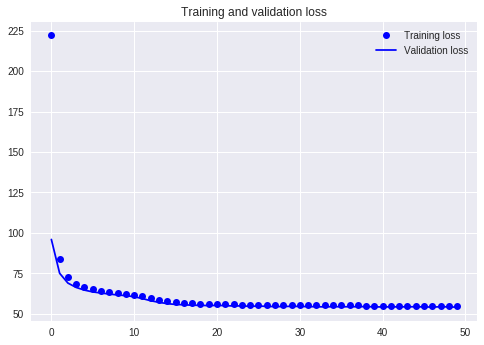

In [44]:
# plot loss history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

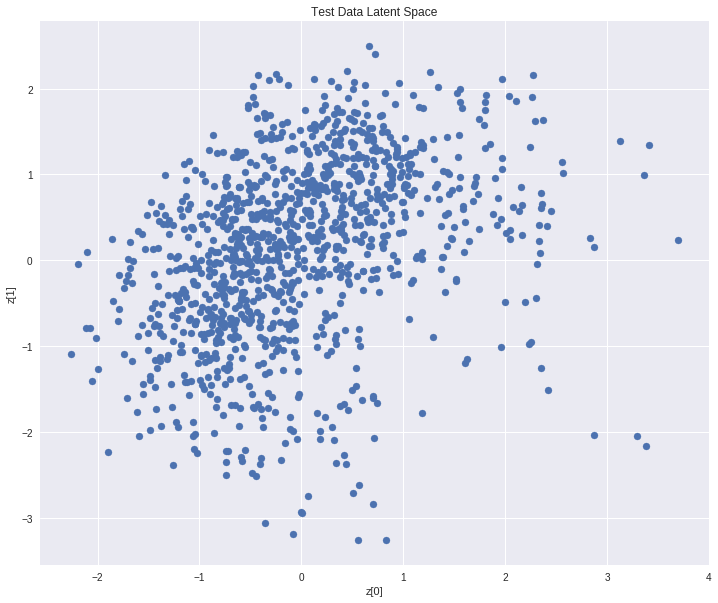

In [45]:
# Visualization of latent space
z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1])
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title('Test Data Latent Space')
plt.show()

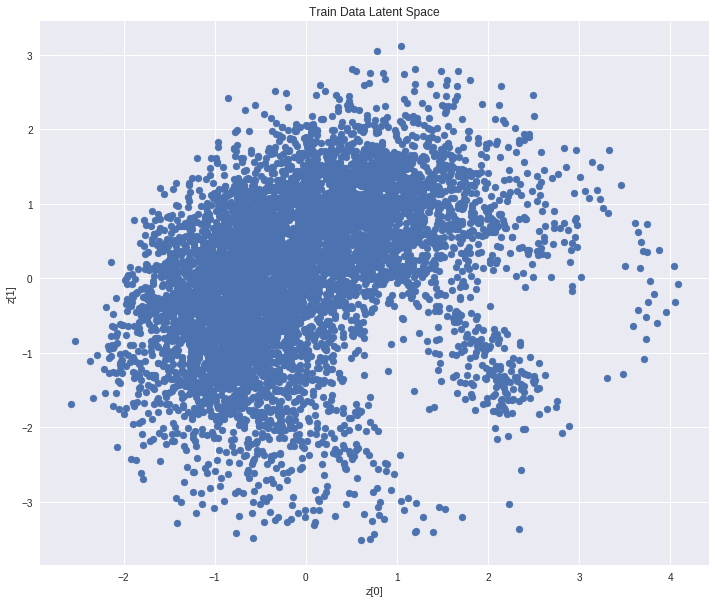

In [46]:
# Visualization of latent space
z_mean, _, _ = encoder.predict(x_train, batch_size=batch_size)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1])
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title('Train Data Latent Space')
plt.show()

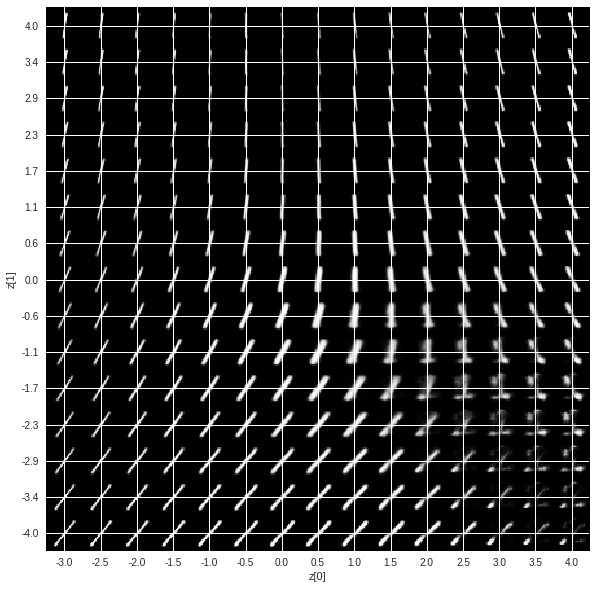

In [47]:
# display a 30x30 2D manifold of digits
    n = 15
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-3, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='gray')
    plt.show()

In [48]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Visualization of Latent Space
When we supply the whole data to the trained VAE, we can see that result is separable
the anomaly digits (digits which is not "one") are outside the distribution of normal latent space.

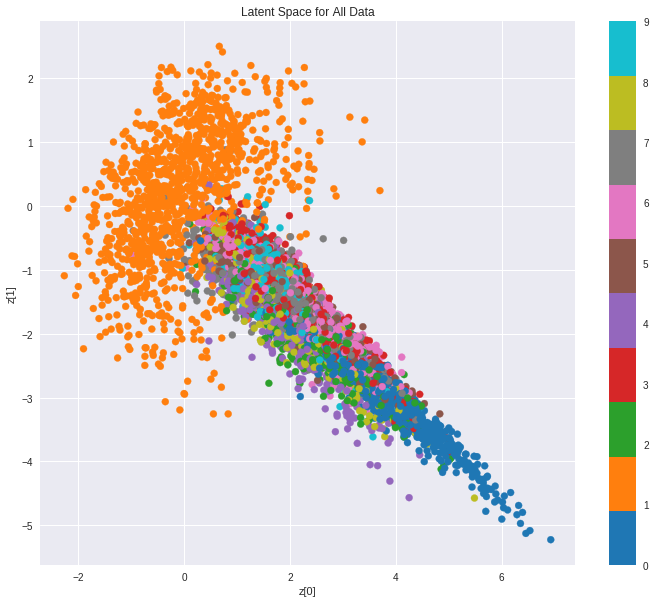

In [49]:
# Visualization of latent space
z_mean,z_log_var, _ = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
plt.colorbar()
plt.set_cmap('tab10')
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title('Latent Space for All Data')
plt.show()

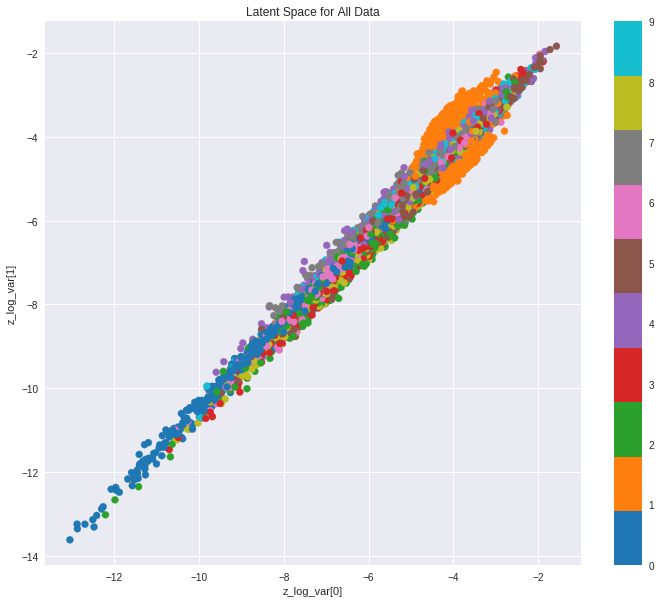

In [50]:
# Visualization of latent space
plt.figure(figsize=(12, 10))
plt.scatter(z_log_var[:, 0], z_log_var[:, 1], c=y_test)
plt.colorbar()
plt.set_cmap('tab10')
plt.xlabel("z_log_var[0]")
plt.ylabel("z_log_var[1]")
plt.title('Latent Space for All Data')
plt.show()

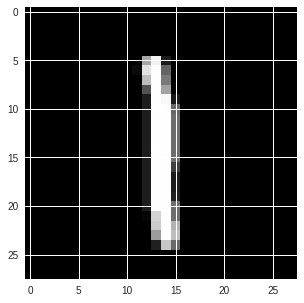

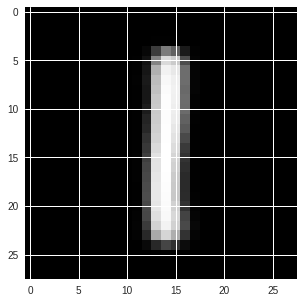

In [51]:
# test reconstruction for one digit

i = 14

digit_size = 28


digit = x_train[i].reshape(digit_size, digit_size)

figure = digit
plt.figure(figsize=(5, 5))
plt.imshow(figure, cmap='gray')
plt.show()



z_sample = np.array(z_mean)
x_decoded = decoder.predict(z_sample)
digit = x_decoded[i].reshape(digit_size, digit_size)


figure = digit
plt.figure(figsize=(5, 5))
plt.imshow(figure, cmap='gray')
plt.show()



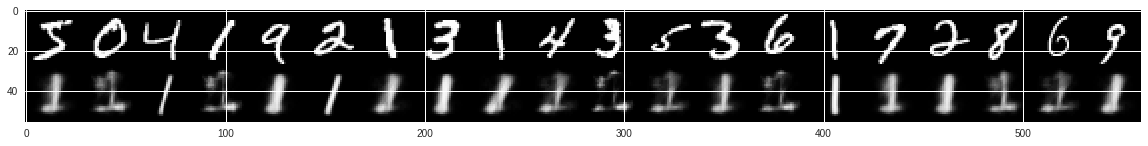

In [52]:
# test reconstruction
    n = 20
    digit_size = 28
    figure = np.zeros((digit_size * 2, digit_size * n))
    grid_x = np.linspace(0, n, n)


    for j, xi in enumerate(grid_x):
        z_sample = np.array(z_mean)
        x_decoded = decoder.predict(z_sample)
        digit = x_train[j].reshape(digit_size, digit_size)
        figure[0 * digit_size: (0 + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
        digit = x_decoded[j].reshape(digit_size, digit_size)
        figure[1 * digit_size: (1 + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(n, n))
    
    plt.imshow(figure, cmap='gray')
    plt.show()